In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

plt.style.use('fivethirtyeight')

In [292]:
data_path = './Data/SteamCharts 2.csv'
df = pd.read_csv(data_path, encoding='unicode_escape') # Needs special encoding to read the file

In [293]:
df.head()

,gamename,year,month,avg,gain,peak,avg_peak_perc
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%


In [294]:
df['month'][0]

'February '

In [295]:
month_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df['month'] = df['month'].str.strip() # Strip whitespace
df['month'] = df['month'].map(month_to_num) # Map month names to numbers
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83789 entries, 2021-02-01 to 2017-03-01
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gamename       83789 non-null  object 
 1   year           83789 non-null  int64  
 2   month          83789 non-null  int64  
 3   avg            83789 non-null  float64
 4   gain           82529 non-null  float64
 5   peak           83789 non-null  int64  
 6   avg_peak_perc  83789 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 5.1+ MB


In [297]:
df.describe()

,year,month,avg,gain,peak
count,83789.000000,83789.000000,8.378900e+04,82529.000000,8.378900e+04
mean,2017.338708,6.546420,2.792017e+03,-10.245559,5.518877e+03
std,2.237587,3.513198,2.648480e+04,3789.944005,5.015571e+04
min,2012.000000,1.000000,0.000000e+00,-250248.990000,0.000000e+00
25%,2016.000000,3.000000,5.325000e+01,-38.310000,1.380000e+02
50%,2018.000000,7.000000,2.042700e+02,-1.630000,5.020000e+02
75%,2019.000000,10.000000,7.716500e+02,22.320000,1.741000e+03
max,2021.000000,12.000000,1.584887e+06,426446.120000,3.236027e+06


In [298]:
df.isna().sum()

gamename            0
year                0
month               0
avg                 0
gain             1260
peak                0
avg_peak_perc       0
dtype: int64

For every month with a previous documented month we can calculate the gain from avg. With the rest of them we can use an imputer.

In [299]:
df['gain'] = df['avg'].pct_change().fillna(df['gain']) * 100

df.isna().sum()

gamename          0
year              0
month             0
avg               0
gain             30
peak              0
avg_peak_perc     0
dtype: int64

In [300]:
print(df['gain'].unique())

[-2.19642000e+05  2.96407659e-01 -3.41840417e+00 ...  2.55773430e+01
 -3.64999210e+01 -9.96072194e+01]


In [301]:
df['gain'] = df['gain'].replace([np.inf, -np.inf], np.nan)

In [302]:
imputer = KNNImputer(n_neighbors=2)

df_gain= imputer.fit_transform(df[['gain']])
df['gain'] = df_gain

df

,gamename,year,month,avg,gain,peak,avg_peak_perc
date,,,,,,,
2021-02-01,Counter-Strike: Global Offensive,2021,2,741013.24,-219642.000000,1123485,65.9567%
2021-01-01,Counter-Strike: Global Offensive,2021,1,743209.66,0.296408,1124553,66.0893%
2020-12-01,Counter-Strike: Global Offensive,2020,12,717803.75,-3.418404,1164396,61.646%
2020-11-01,Counter-Strike: Global Offensive,2020,11,668754.58,-6.833228,1037464,64.4605%
2020-10-01,Counter-Strike: Global Offensive,2020,10,613666.69,-8.237385,943876,65.0156%
...,...,...,...,...,...,...,...
2017-07-01,Steel Division: Normandy 44,2017,7,421.60,49.233655,987,42.7153%
2017-06-01,Steel Division: Normandy 44,2017,6,906.74,115.071157,2584,35.0906%
2017-05-01,Steel Division: Normandy 44,2017,5,1138.66,25.577343,4606,24.7212%


Text(0.5, 1.0, 'Gain of Steam Games Popularity')

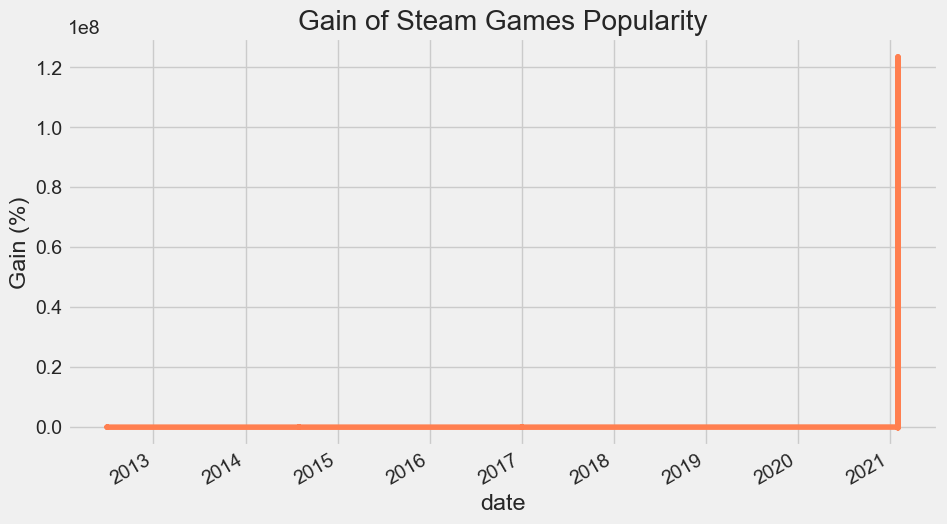

In [303]:
fig, ax = plt.subplots(figsize=(10, 6))

df['gain'].plot(ax=ax, color='coral', label='Gain')
ax.set_ylabel('Gain (%)')
ax.set_title('Gain of Steam Games Popularity')

In [304]:
mean_gain = df['gain'].mean()
std_gain = df['gain'].std()
threshold = 3

outliers = df[(df['gain'] - mean_gain).abs() / std_gain > threshold]

df.drop(outliers.index, inplace=True)

Text(0.5, 1.0, 'Gain of Steam Games Popularity')

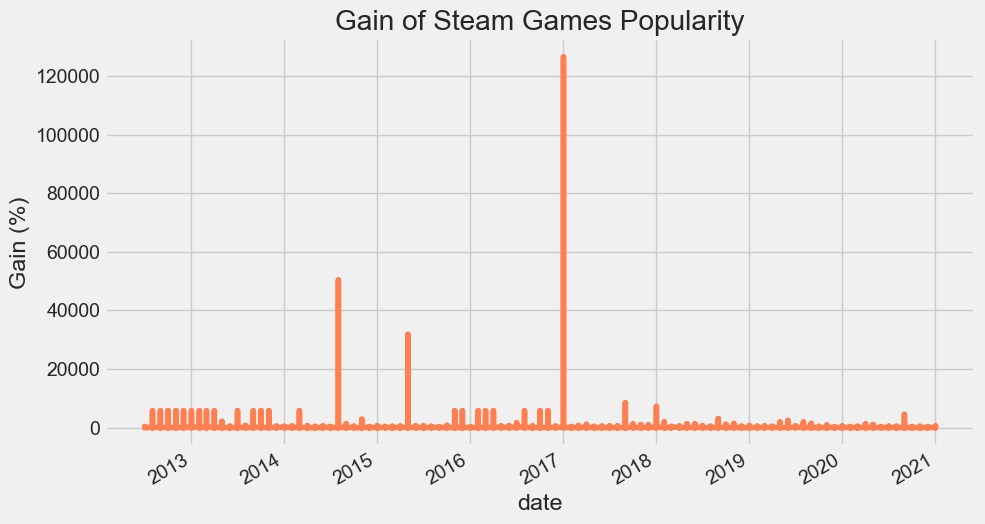

In [305]:
fig, ax = plt.subplots(figsize=(10, 6))

df['gain'].plot(ax=ax, color='coral', label='Gain')
ax.set_ylabel('Gain (%)')
ax.set_title('Gain of Steam Games Popularity')

Text(0.5, 1.0, 'Average Players of Steam Games')

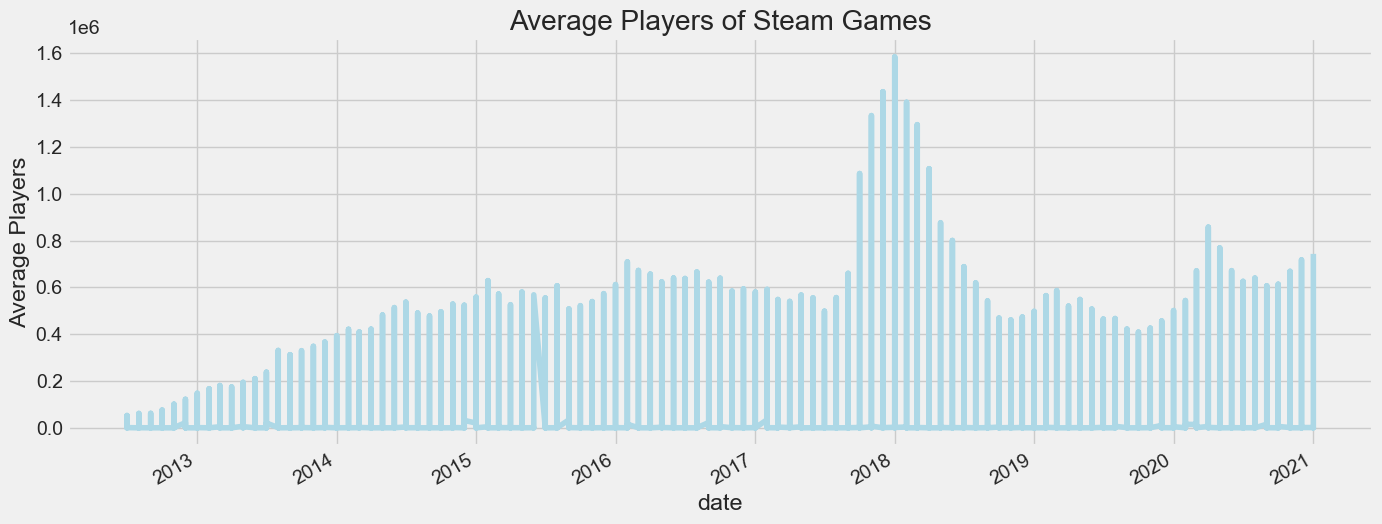

In [306]:
fig, ax = plt.subplots(figsize=(15, 6))

df['avg'].plot(ax=ax, color='lightblue', label='Average Players')
ax.set_ylabel('Average Players')
ax.set_title('Average Players of Steam Games')

In [307]:
df['gamename'].unique().size


1260

In [308]:
encoder = ce.BinaryEncoder(cols=['gamename'])

df_encoded = encoder.fit_transform(df['gamename'])

df = pd.concat([df.drop('gamename', axis=1), df_encoded], axis=1)
df

,year,month,avg,gain,peak,avg_peak_perc,gamename_0,gamename_1,gamename_2,gamename_3,gamename_4,gamename_5,gamename_6,gamename_7,gamename_8,gamename_9,gamename_10
date,,,,,,,,,,,,,,,,,
2021-01-01,2021,1,743209.66,0.296408,1124553,66.0893%,0,0,0,0,0,0,0,0,0,0,1
2020-12-01,2020,12,717803.75,-3.418404,1164396,61.646%,0,0,0,0,0,0,0,0,0,0,1
2020-11-01,2020,11,668754.58,-6.833228,1037464,64.4605%,0,0,0,0,0,0,0,0,0,0,1
2020-10-01,2020,10,613666.69,-8.237385,943876,65.0156%,0,0,0,0,0,0,0,0,0,0,1
2020-09-01,2020,9,606850.32,-1.110761,977769,62.0648%,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-01,2017,7,421.60,49.233655,987,42.7153%,1,0,0,1,1,1,0,1,1,0,0
2017-06-01,2017,6,906.74,115.071157,2584,35.0906%,1,0,0,1,1,1,0,1,1,0,0
2017-05-01,2017,5,1138.66,25.577343,4606,24.7212%,1,0,0,1,1,1,0,1,1,0,0
